## Overview

> You can use the function `ProcessImage()` to segment and extract quantititative values from a single plate image. The default is to extract only size features, which include the patch area, average pixel intensity, sum of pixel intensities, and perimeter. However, you can also extract texture features which include the variance of pixel intensities, the "complexity score" of the patch, and 10 [local binary pattern scores](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html) reflecting performing the LBP transform with a neighborhood of 9 pixels. The complexity score is calculated by taking the [sobel transform](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.sobel) twice, summing over the patch area and then dividing by the patch area.


## Function Use
```
df, tiles, masks, corners = PyPl8.ProcessImage(file, sourcefolder, outputfolder,
                                               crop_method = 'Auto', crop_param = None, adjust = True, rotate = False, 
                                               s = 200, array_dimensions = (8,12), 
                                               pin_size = 25, features = 'size', save = True, 
                                               display = False, calibrate = False)
```

### Parameters
- **file:** *string (required)* Name of image to be processed including file extension
- **sourcefolder:** *string (required)* Path to folder containing images to be processed
- **outputfolder:** *string (required)* Path to desired location for function output to be saved. If the folder does not exist, it will be created during processing as long as it is a valid path. If you are using save = False, then you can provide a dummy variable like [] in place of a folder path. 
- **crop_method:** *string (optional)* There are 3 possible methods for pre-processing the images. The default value is `'Auto'`, which detects the agar plate by thresholding the whole image and then estimates pin locations based on the plate shape. This method generally works well when plates are placed parallel to the edges of the photo and the majority of patches have significant growth. It relies fairly heavily on the autoadjustment after initial guess, so if lots of patches are not growing well it fails because there is not a good reference point to adjust to. A second option is `'Grid'`, in which the user inputs the position of the center of patch A1 either through `crop_param` or upon viewing the image in the notebook. On a windows or mac operating system, you can also use the '`Click`' option, which will open the image in another window and you can click on the A1 location to provide the necessary reference point. See example notebook for more information on how to use the `Click` option.
- **features:** *string (optional)* The default value is `'size'`, which will extract the area, average pixel intensity, total pixel sum, and perimeter of each patch. If you want to additionally extract texture features, set `features = 'all'`.
- **pin_size:** *integer (optional)* Estimated minimum patch radius in pixels, which corresponds to the radius of the pin used to place cells. The default value is 25, which is the lowest size that has fit experimental data from the Dudley lab. For the funnel cross data, a pin size of 28 was used. If you set pin_size = 0, then during the segmentation step, otsu thresholding alone will be used and circle detection will be skipped. 
- **crop_param:** *tuple of integers (optional)* When using the `'Grid'` crop method you can enter an estimate of the location of the center of patch A1 in the form (row, column) instead of using the image display step. By default the value of crop_param is None, but a reference location of A1 = (600,600) is used. Note that the location (0,0) indicates the top left corner of the image.
- **s:** *integer (optional)* The side length of desired square regions of interest in pixels. The default value is 200 pixels.
- **array_dimensions:** *tuple of integers (optional)* The dimensions of the patch lay out on the plate in the form (number of rows, number of columns). The default value is (8,12). 
- **adjust:** *boolean (optional)* The default value is True. When True, adjust will perform a preliminary segmentation of each ROI and shift it so that the ROI is centered on the largest object in that intial area. If an ROI does not contain any detectable objects at this initial pass, it will be recentered based on the mean change in other patches in that row and column. For tricky images with lots of null growth I suggest carefully calibrating the reference point for the `Grid` cropping option, perhaps with a widget as shown below, and setting `adjust = False`. 
- **rotate:** *boolean (optional)* The default value is `False`. When `True`, plate images will be rotated 180 degrees before being processed. 
- **save:** *boolean (optional)* The default value is `True`. When `True`, the dataframe of quantitative outputs will be saved to the output folder as a csv file and the segmented image will be saved to the output folder as a jpg file. If `False`, nothing will be saved.
- **display:** *boolean (optional)* The default value is `False`. When true, the segmented image will be displayed to the screen after processing. 
- **calibrate:** *boolean (optional)* The default value is `False`. If using `Grid` crop, you can set `calibrate = True` in order to see the image displayed in line and enter the location of the center of patch A1. Note that the location (0,0) indicates the top left corner of the image. 

### Returns
- **dataframe:** *pandas dataframe* If you want to explore the output from image processing in the jupyter notebook, pandas can be useful. Each row corresponds to a patch and each column contains the specified features. 
- **tiles:** *list of grayscale images* In case you want to reference the images that correspond to the data points in the data frame, you can use this list of tiles. They are ordered the same way as the dataframe. 
- **masks:** *list of binary images* To segment the tiles and look at the segmentation that corresponds to each data point, multiply the masks and tiles together. 
- **corners:** *list of tuples* This is a list of the location of the top left corner of each tile within the original image. It is used when reconstructing the segmented images. 

## Examples

### Example 1: Use 'Auto' cropping.

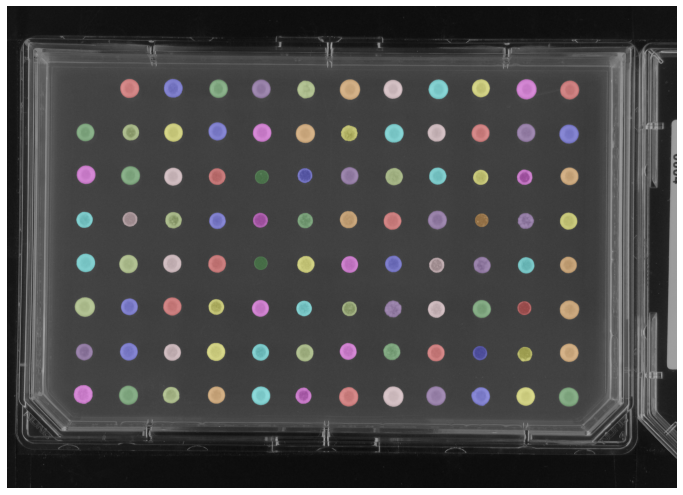

In [1]:
from PyPl8 import ProcessImage

image_folder = r'C:\Users\PythonFolder\ExampleImages'
file = 'YCR71P01_CF_24h_12-20-45.jpg'

df, _ , _ , _ = ProcessImage(file, image_folder, None, save = False, display = True)

['Position', 'Area', 'AvgInt', 'PixelSum', 'Background', 'Perimeter']

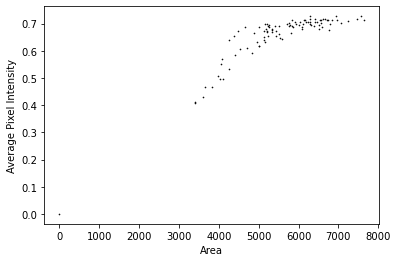

In [2]:
import matplotlib.pyplot as plt

plt.plot(df.Area, df.AvgInt, 'k.', markersize=1.25);
plt.xlabel('Area')
plt.ylabel('Average Pixel Intensity')
list(df)

###  Example 2: Use the 'Grid' method without auto-adjustment to calibrate pre-segmentation cropping.

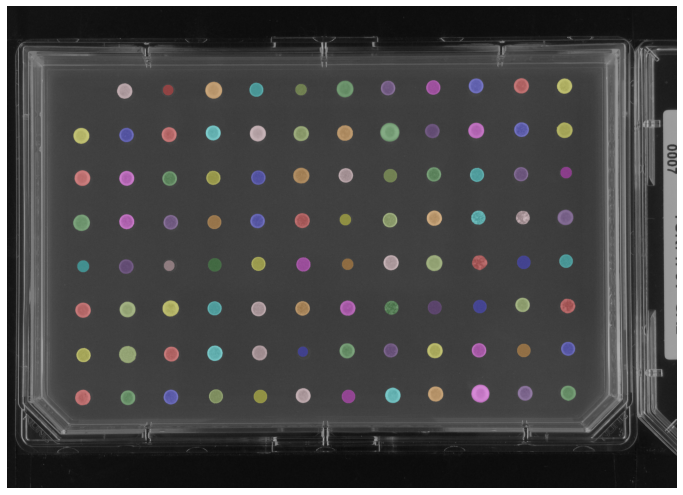

In [4]:
image_folder = r'C:\Users\PythonFolder\ExampleImages'
file = 'YCR71P01_GAL_24h_12-19-36.jpg'

df, _ , _ , _ = ProcessImage(file, image_folder, None, 
                             crop_method = 'Grid', calibrate = True, adjust = False, 
                             save = False, display = True)

### Example 3: Use a widget to click on image to collect reference point for cropping.

In [20]:
%matplotlib widget
from skimage import io
from skimage.io import imread
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import ipywidgets as wdg 
import numpy as np
import os

# Define a click function that will record the reference point indicated and display the corresponding tiles
def onclick(event):
    global clickcount, refPt
    if clickcount == 0:  
        clickcount +=1
        temp = str(event).split('(')[2]
        temp1 = temp.split(')')[0]
        temp2 = temp1.split(' ')[0]
        temp3 = temp2.rstrip(temp2[-1])
        temp4 = temp1.split(' ')[1]
        refPt = (round(float(temp4)),round(float(temp3)))# Update the reference point
        ax.plot(round(float(temp3)),round(float(temp4)),'r.') # plot clicked point
        # Plot tile boundaries
        s = 200
        r1 = round(float(temp4))
        r2 = r1 + (8-1/2)*s # 8 is the number of rows
        c1 = round(float(temp3))
        c2 = c1 + (12- 1/2)*s*1.02 # 12 is the number of columns
        rps = np.linspace(r1,r2,8)
        cps = np.linspace(c1,c2,12)

        for r in rps:
            for c in cps:
                r1 = int(r-s/2)
                c1 = int(c-s/2)
                rect = patches.Rectangle((c1, r1), s, s, linewidth=1.2, edgecolor='b', facecolor='none')
                ax.add_patch(rect)        
    else:
        fig.canvas.mpl_disconnect(cid)

In [21]:
#Import image
os.chdir(image_folder)
file = 'YCR71P01_CHX_12-20-03.jpg'
image = io.imread(file)

#Show the image with matplotlib
clickcount = 0
refPt = None

fig, ax = plt.subplots(figsize = (8,6));
ax.imshow(image)
ax.axis('off')
plt.show()

# Collect user input
cid = fig.canvas.mpl_connect('button_press_event', onclick)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
print(refPt)

(615, 563)


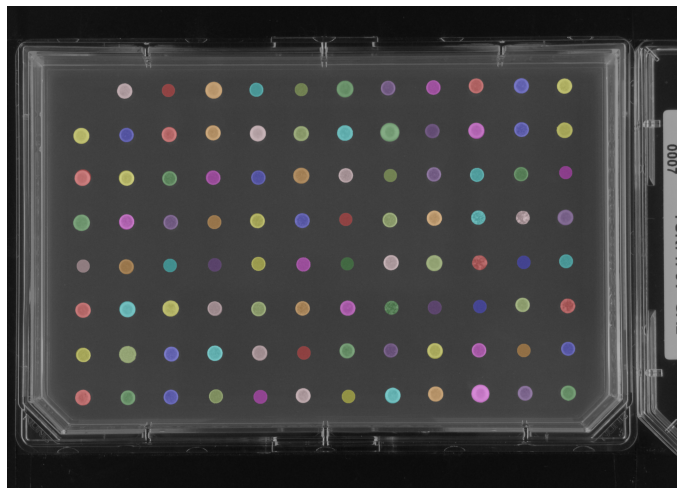

In [8]:
%matplotlib inline
df, _ , _ , _ = ProcessImage(file, image_folder, None, 
                             crop_method = 'Grid', crop_param = refPt, calibrate = False,
                             pin_size = 32, save = False, display = True)

### Example 4: Test different pin sizes.

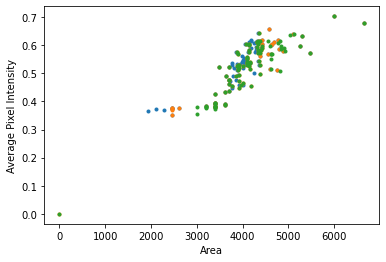

In [15]:
%matplotlib inline
for p in [25, 28, 31]:
    df, _ , _ , _ = ProcessImage('YCR71P01_GAL_24h_12-19-36.jpg', image_folder, None, pin_size = p,
                                 crop_method = 'Grid', crop_param = (600,550), calibrate = False,
                                 save = False, display = False)
    plt.plot(df.Area, df.AvgInt, '.');
    plt.xlabel('Area')
    plt.ylabel('Average Pixel Intensity')

### Example 5: Use intensity thresholding without circle detection for thresholding.

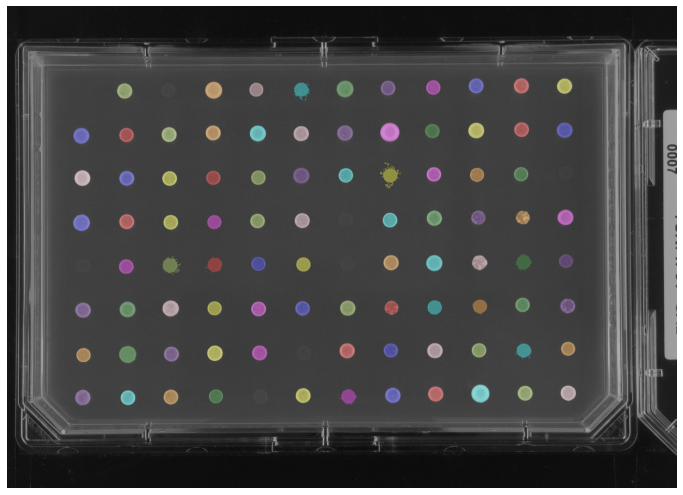

In [16]:
file = 'YCR71P01_GAL_24h_12-19-36.jpg'

df, _ , _ , _ = ProcessImage(file, image_folder, None, crop_method = 'Grid', calibrate = True, 
                             save = False, display = True, pin_size = 0)

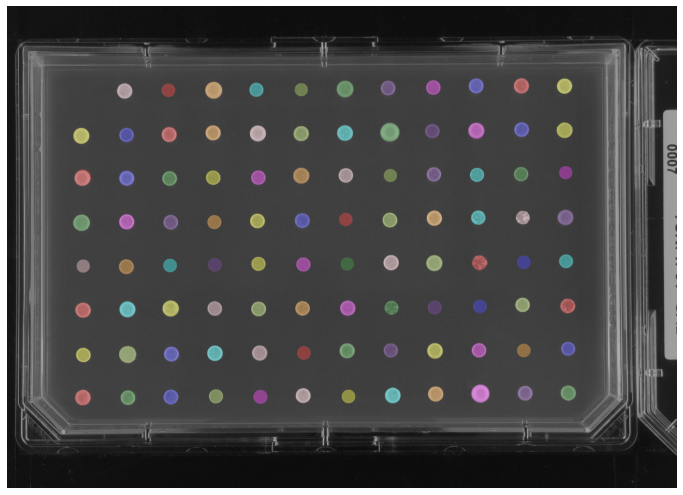

In [18]:
df, _ , _ , _ = ProcessImage(file, image_folder, None, crop_method = 'Grid', crop_param = (600,575), 
                             save = False, display = True, pin_size = 32)